# **Laboratorio N°2 - SIS420**

## **Introducción.**

  En este cuadernillo de Python, abordaremos el proceso de entrenamiento y evaluación de modelos de regresión multivariable utilizando un dataset específico. El objetivo principal es comprender y aplicar diferentes técnicas de regresión, incluyendo la regresión lineal multivariable, la regresión polinómica y el cálculo de parámetros por la ecuación normal. Utilizaremos un conjunto de datos que cumpla con ciertos criterios establecidos, incluyendo al menos 10 propiedades y más de 10,000 ejemplos.

## **Objetivos.**
  - Seleccionar un dataset adecuado que cumpla con los requisitos de tamaño y características necesarias.
  - Implementar modelos de regresión lineal multivariable, regresión polinómica y cálculo de parámetros por la ecuación normal en Python.
  - Entrenar y validar cada modelo utilizando técnicas adecuadas de división de datos y validación cruzada.
  - Evaluar la efectividad de cada modelo mediante la realización de predicciones y análisis de métricas de evaluación.
  - Generar gráficos de costo para cada modelo y explicar su comportamiento.



In [2]:
print(f"Laboratorio N°2 - SIS420: Limachi Villarroel Alan Nicolas.")
print(f"Carrera: Ingeniería en Ciencias de la Computación.")

Laboratorio N°2 - SIS420: Limachi Villarroel Alan Nicolas.
Carrera: Ingeniería en Ciencias de la Computación.


**(0) Montar Google Drive en Colaboratoy.**  Una vez que el Google Drive está montado, puedes acceder a los archivos almacenados en tu Google Drive directamente desde el entorno de Colaboratory.

In [4]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


**(1) Establecimiento de las Librerías.** Se importan las librerías necesarias para el desarrollo del proyecto. Esto incluye librerías para manejo de directorios y rutas, computación vectorial y científica, así como librerías para la visualización y trazado de gráficos, además se configura Matplotlib para que las gráficas se muestren de manera integrada en el cuaderno.

In [5]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from scipy import optimize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shutil
%matplotlib inline

**(a) Establecimiento de las Funciones a usar en todo este cuadernillo.** Dado que las funciones no varían con respecto al modelo de regresión, es muy conveniente tenerlas en esta parte, así la mayor parte del código tendrá un mayor entendimiento.

*(i) Normalizar Características.* Esta función se utiliza para normalizar las características de la matriz de características X, lo que significa que ajusta los valores de las características para que tengan una media de cero y una desviación estándar de uno. La normalización de características es importante en algoritmos de aprendizaje automático, especialmente en aquellos que se basan en medidas de distancia, como la regresión lineal o el descenso de gradiente. La normalización ayuda a que el algoritmo converja más rápido y a evitar problemas relacionados con diferentes escalas de las características.

In [6]:
def normalizarCaracteristicas(X):
    X_norm = X.copy()
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    sigma[sigma == 0] = 1
    X_norm = (X - mu) / sigma
    return X_norm, mu, sigma

*(ii) Graficar Datos.* Esta función se utiliza para visualizar los datos de entrada. Toma dos vectores x e y, que representan las características y la variable objetivo respectivamente, y etiquetas para los ejes x e y. La función crea un gráfico de dispersión donde cada punto representa una instancia de los datos, con las características en el eje x y la variable objetivo en el eje y. Esta función es útil para comprender la distribución de los datos y visualizar posibles relaciones entre las características y la variable objetivo.

In [7]:
def graficarDatos(x, y, xlabel, ylabel):
    plt.figure()
    plt.plot(x, y, 'ro')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

def graficarDatosSE(x, y):
    plt.figure()
    plt.plot(x, y, 'ro', markersize=5)
    plt.xlabel('% Iron Feed')
    plt.ylabel('% Silica Feed')

*(iii) Calcular Costo.* Esta función se utiliza para calcular el costo de un modelo de regresión lineal dado un conjunto de parámetros θ. El costo se calcula utilizando la función de costo de la regresión lineal, que es la suma de los errores al cuadrado entre las predicciones del modelo y los valores reales de la variable objetivo. El objetivo es minimizar este costo ajustando los parámetros θ del modelo.

In [8]:
def calcularCosto(X, y, theta):
    m = y.size
    J = 0
    h = np.dot(X, theta)
    J = (1/(2 * m)) * np.sum(np.square(np.dot(X, theta) - y))
    return J

*(iv) Calcular Descenso por el Gradiente.* Esta función implementa el algoritmo de descenso por el gradiente para minimizar la función de costo de un modelo de regresión lineal. Dado un conjunto de datos de entrada X, valores de la variable objetivo y, parámetros iniciales θ, tasa de aprendizaje α y número de iteraciones, la función ajusta los parámetros θ para minimizar el costo utilizando el gradiente descendente. En cada iteración, se actualizan los parámetros θ en la dirección opuesta al gradiente de la función de costo.

In [9]:
def calcularDescensoGradiente(X, y, theta, alpha, numero_iteraciones):
    m = y.shape[0]
    theta = theta.copy()
    J_historico = []
    for i in range(numero_iteraciones):
        theta = theta - (alpha / m) * (np.dot(X, theta) - y).dot(X)
        J_historico.append(calcularCosto(X, y, theta))
    return theta, J_historico

*(v) Ecuación de la Normal.* Esta función implementa la ecuación de la normal para calcular los parámetros θ de un modelo de regresión lineal de forma cerrada y analítica, en lugar de utilizar el método iterativo del descenso por el gradiente. La ecuación de la normal calcula los valores óptimos de θ que minimizan la función de costo sin necesidad de iteraciones. Esto puede ser útil cuando el número de características es pequeño y el conjunto de datos de entrenamiento no es demasiado grande.

In [11]:
def ecuacionNormal(X, y):
    theta = np.zeros(X.shape[1])
    theta = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)
    return theta

**(b) Generación de los Datos para futuras Predicciones.** Se generarán datos para ponerlos a prueba posteriormente para cada modelo, así se podrán comparar los diversos resultados. Adicionalmente se establecen las columnas de el dataset.

In [12]:
'''
info = np.array(['median7', 'median14', 'median21', 'median28', 'median35', 'median42', 'median49', 'median7_h', 'median14_h', 'median21_h', 'median28_h', 'median35_h', 'median42_h',
                 'median49_h', 'holiday', 'holiday_log'])
'''



"\ninfo = np.array(['median7', 'median14', 'median21', 'median28', 'median35', 'median42', 'median49', 'median7_h', 'median14_h', 'median21_h', 'median28_h', 'median35_h', 'median42_h',\n                 'median49_h', 'holiday', 'holiday_log'])\n"

**(2) Regresión Lineal Multivariable.** La regresión lineal multivariable es una extensión del modelo de regresión lineal simple que permite modelar la relación entre una variable dependiente y múltiples variables independientes. En el caso de la regresión lineal multivariable, la relación entre las variables se modela como una combinación lineal de los predictores.

**(a) Carga del dataset.** Primeramente se debe acceder al dataset respectivo para poder trabajar con el mismo:

In [15]:
dataset = pd.read_csv('/content/gdrive/MyDrive/SIS420/Laboratorio_2_SIS420/cuadernillos y datasets/validation_score.csv', delimiter=',')
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=9)
X_train, y_train = train_set.iloc[:, 1:-1], train_set["yearly_log"]
X_test, y_test = test_set.iloc[:, 1:-1], test_set["yearly_log"]
X_train = np.concatenate([np.ones((X_train.shape[0], 1)), X_train], axis=1)
X_test = np.concatenate([np.ones((X_test.shape[0], 1)), X_test], axis=1)

**(b) Normalización de las características.** Al normalizar las características, se reduce la variación en las escalas de las características, lo que puede acelerar el proceso de convergencia de los algoritmos de optimización, como el descenso de gradiente. Esto significa que el modelo puede converger más rápidamente hacia una solución óptima.

In [16]:
X_train, mu, sigma = normalizarCaracteristicas(X_train)
print('Media calculada:', mu)
print('Desviación estándar calculada:', sigma)

Media calculada: [1.         0.47287028 0.46651703 0.46575311 0.46878161 0.47084911
 0.47405717 0.47805328 0.47752746 0.46605901 0.46266931 0.46412016
 0.46539994 0.46786866 0.47165315 0.92010276 0.58611656]
Desviación estándar calculada: [1.         0.3107359  0.30829325 0.30718677 0.30994478 0.31162829
 0.31411801 0.31680422 0.31086071 0.30838986 0.30743498 0.30955609
 0.31183322 0.31404095 0.31661109 0.60018124 0.40651062]


**(c) Inicialización de parámetros y cálculo del costo inicial.** Se inicializan los parámetros del modelo de regresión lineal (θ) a cero y se calcula el costo inicial utilizando la función calcularCosto(). Este costo inicial es la medida de qué tan bien se ajusta el modelo a los datos en su estado inicial.

In [19]:
theta = np.zeros(X_train.shape[1])
costo_inicial = calcularCosto(X_train, y_train, theta)
print(f"Costo inicial con theta = {theta}: {costo_inicial}")

Costo inicial con theta = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]: 0.27872968015172533


**(d) Descenso del Gradiente.** Se utiliza el descenso de gradiente para encontrar los parámetros θ que minimizan la función de costo. La función calcularDescensoGradiente() se encarga de realizar las actualizaciones de θ en cada iteración del descenso de gradiente.

In [20]:
alpha = 0.01
numero_iteraciones = 1500
theta, J_historico = calcularDescensoGradiente(X_train, y_train, theta, alpha, numero_iteraciones)
print(f"Theta calculado mediante descenso de gradiente: {theta}")
print(f"Costo final después de descenso de gradiente: {J_historico[-1]}")

Theta calculado mediante descenso de gradiente: [ 0.          0.01003242 -0.0082233  -0.01163759 -0.01443584 -0.0079169
 -0.01171916 -0.01241356  0.03564267  0.01104453  0.00792728  0.01098954
  0.01981447  0.01615754  0.01255968  0.05122783  0.22523053]
Costo final después de descenso de gradiente: 0.23560247312280092


**(e) Gráfica del costo en función del número de iteraciones.** Se realiza una gráfica del costo (J) en función del número de iteraciones del descenso de gradiente. Esta gráfica muestra cómo el costo disminuye con cada iteración y permite verificar si el algoritmo está convergiendo correctamente.

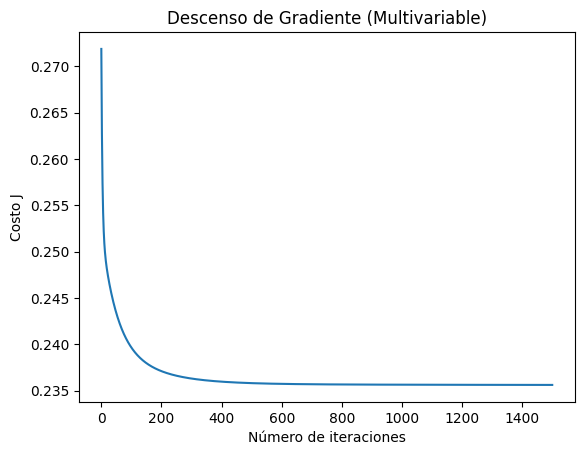

In [21]:
plt.figure()
plt.plot(np.arange(len(J_historico)), J_historico)
plt.xlabel('Número de iteraciones')
plt.ylabel('Costo J')
plt.title('Descenso de Gradiente (Multivariable)')
plt.show()

**(f) Generar predicciones.** Se usan los datos anteriormente generados para comprobar la efectividad del modelo.

In [46]:
pred = np.dot(X_test[:200], theta)
print(f"Datos predichos para los datos de prueba:")
print(pred)
precision = np.mean(pred == y_test[:200]) * 100
print("Precisión de las predicciones en el conjunto de prueba: {:.2f}%".format(precision))

Datos predichos para los datos de prueba:
[0.07279096 0.11498451 0.25033778 0.10245566 0.5476745  0.22704463
 0.18685249 0.06337585 0.25579027 0.24460733 0.2292983  0.38450799
 0.23430351 0.31410072 0.19319789 0.17234936 0.28515316 0.0967267
 0.26065718 0.24132308 0.02287837 0.14930752 0.40170518 0.06892023
 0.11573608 0.15853941 0.06383566 0.08399262 0.25650518 0.21419292
 0.20443207 0.104956   0.17343679 0.10486808 0.052775   0.21834938
 0.17006684 0.19904063 0.07192944 0.20539438 0.36724958 0.35594497
 0.09256301 0.08695549 0.15390274 0.36953231 0.27555776 0.48851804
 0.0502299  0.10410332 0.06971482 0.27273464 0.1627876  0.22916667
 0.21848115 0.18295355 0.21841694 0.17073958 0.10948647 0.24817185
 0.37195675 0.19139677 0.06034006 0.07853544 0.06889293 0.13572888
 0.26040839 0.14064779 0.19569862 0.11415361 0.14805754 0.08242652
 0.17663383 0.23616518 0.20388536 0.27617534 0.20217925 0.2212071
 0.11503951 0.3684187  0.07130078 0.14727707 0.12560158 0.1729999
 0.14203348 0.13823975 

**(3) Regresión Polinómica.** La regresión polinómica es una técnica en la que se ajusta un modelo polinómico a los datos, en lugar de un modelo lineal como en la regresión lineal simple o multivariable. En este caso, se pueden modelar relaciones no lineales entre las variables.

**(a) Cargar del dataset.** Se carga el conjunto de datos necesario para el entrenamiento del modelo de regresión polinómica.

In [23]:
data = pd.read_csv('/content/gdrive/MyDrive/SIS420/Laboratorio_2_SIS420/cuadernillos y datasets/validation_score.csv', delimiter=',')
X, y = dataset.iloc[:, 1:-1].values, dataset["yearly_log"]
m = y.size

**(b) Normalizar los datos.** Se normalizan las características del conjunto de datos para facilitar el entrenamiento del modelo de regresión polinómica.

In [24]:
X_norm, mu, sigma = normalizarCaracteristicas(X)
X_ready = np.concatenate([np.ones((m, 1)), X_norm], axis=1)

**(c) Calcular el costo.** Se calcula el costo inicial del modelo de regresión polinómica antes de comenzar el proceso de entrenamiento.

In [25]:
theta1 = np.zeros(X_ready.shape[1])
costo_inicial = calcularCosto(X_ready, y, theta1)
print(f"Costo inicial con theta = {theta1}: {costo_inicial}")

Costo inicial con theta = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]: 0.2795684422252419


**(d) Calcular descenso por el gradiente.** Se implementa el algoritmo de descenso del gradiente para ajustar los parámetros del modelo de regresión polinómica y minimizar el costo.

In [26]:
alpha = 0.01
numero_iteraciones = 1500
theta1, J_historico = calcularDescensoGradiente(X_ready, y, theta1, alpha, numero_iteraciones)
print(f"Theta calculado mediante descenso de gradiente: {theta1}")
print(f"Costo final después de descenso de gradiente: {J_historico[-1]}")

Theta calculado mediante descenso de gradiente: [ 0.61265094  0.01072555 -0.00835044 -0.01299862 -0.01499854 -0.00817768
 -0.01225306 -0.01305206  0.03547717  0.01120023  0.00831279  0.01182815
  0.02064825  0.0167271   0.0130867   0.05203114  0.22496511]
Costo final después de descenso de gradiente: 0.048579002303476296


**(e) Graficar convergencia de costo.** Se grafica el costo del modelo en función del número de iteraciones del algoritmo de descenso del gradiente para evaluar su convergencia en el contexto de la regresión polinómica.

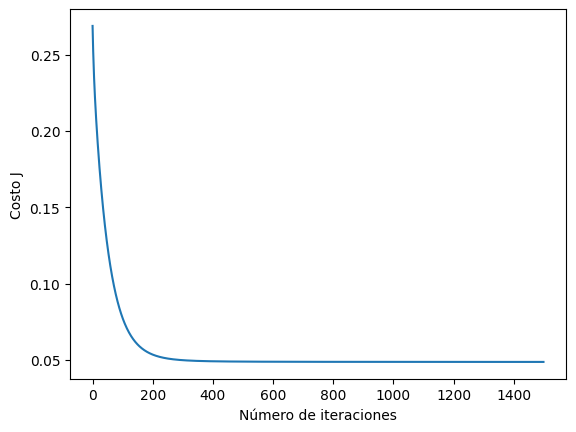

In [27]:
plt.figure()
plt.plot(np.arange(len(J_historico)), J_historico)
plt.xlabel('Número de iteraciones')
plt.ylabel('Costo J')
plt.show()

**(f) Ajustar regresión lineal.** Se ajusta la regresión polinómica utilizando los parámetros estimados. Degree se pone en 2 a diferencia de los otros cuadernillos porque genera un sobrecargo de memoria en Colab y no puede procesarse.

In [28]:
pf = PolynomialFeatures(degree=2)
X_polynomial = pf.fit_transform(X_ready)
regresion_lineal = LinearRegression()
regresion_lineal.fit(X_polynomial, y)

LinearRegression()

**(g) Parámetros estimados** Se obtienen los parámetros estimados del modelo de regresión polinómica después de entrenarlo.

In [29]:
print('Theta (parámetros) = ' + str(regresion_lineal.coef_) + ', b = ' + str(regresion_lineal.intercept_))

Theta (parámetros) = [ 1.59268369e+04 -2.43644325e+09  2.35981636e+08  2.52442117e+08
 -8.73344823e+07 -6.89889320e+07 -1.97747098e+08  2.04688587e+08
  3.01153944e+08 -2.19422315e+08  9.00228040e+07  1.17656519e+08
  2.45280541e+07  1.96673633e+07 -1.08777484e+08 -6.50371502e+07
  1.24567973e+07 -1.21447581e+07  2.18686333e+07 -2.35981636e+08
 -2.52442117e+08  8.73344823e+07  6.89889319e+07  1.97747098e+08
 -2.04688587e+08 -3.01153944e+08  2.19422315e+08 -9.00228040e+07
 -1.17656519e+08 -2.45280540e+07 -1.96673632e+07  1.08777484e+08
  6.50371503e+07 -1.24567973e+07  1.21447582e+07  5.62563539e-04
  8.84872675e-03 -1.18901730e-02  6.90758228e-04  1.09235644e-02
 -1.19604766e-02  7.22263753e-03 -1.46219134e-02  2.16099024e-02
 -1.18393302e-02  5.39186597e-03 -4.49502468e-03 -3.07622552e-03
 -9.74898785e-03 -9.83157754e-03  1.39318407e-02  9.77647305e-03
  5.09202480e-04 -1.62005424e-04  7.63925910e-03 -7.28687644e-03
 -1.07595325e-03 -1.00207329e-02 -3.78724486e-02  6.90110028e-03
 -7.

**(h) Calcular el error cuadrático medio.** Se calcula el error cuadrático medio del modelo de regresión polinómica para evaluar su desempeño.

In [30]:
prediccion_entrenamiento = regresion_lineal.predict(X_polynomial)
mse = mean_squared_error(y_true=y, y_pred=prediccion_entrenamiento)
rmse = np.sqrt(mse)
r2 = regresion_lineal.score(X_polynomial, y)
print('Error Cuadrático Medio (MSE) = ' + str(mse))
print('Raíz del Error Cuadrático Medio (RMSE) = ' + str(rmse))
print('Coeficiente de Determinación R2 = ' + str(r2))

Error Cuadrático Medio (MSE) = 0.09030911322277119
Raíz del Error Cuadrático Medio (RMSE) = 0.30051474709699555
Coeficiente de Determinación R2 = 0.5086434984288783


**(i) Graficar Modelo.** Se genera una representación gráfica del modelo de regresión polinómica para visualizar su forma.

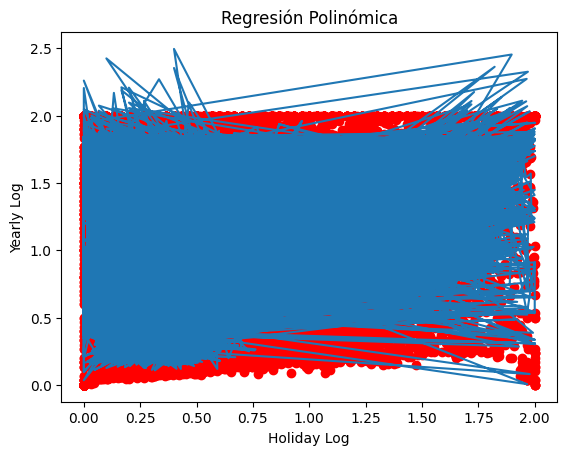

In [32]:
graficarDatos(X[:, 1], y, 'Holiday Log', '%Yearly Log')
plt.plot(X[:, 1], regresion_lineal.predict(X_polynomial), '-')
plt.xlabel('Holiday Log')
plt.ylabel('Yearly Log')
plt.title('Regresión Polinómica')
plt.show()

**(j) Generar Predicciones.**  Se realizan predicciones utilizando el modelo de regresión polinómica entrenado.

In [47]:
y_predicha = np.dot(X_ready[:200], theta1)
print(f"Datos predichos para los datos de prueba:")
print(y_predicha)

Datos predichos para los datos de prueba:
[0.48597527 0.62843149 0.56924016 0.4762401  0.53637164 0.45137534
 0.70739887 0.64031963 0.44407479 0.33617082 0.64262792 0.51687719
 0.53582775 0.64259374 0.37950888 0.52470392 0.65089752 0.44105515
 0.47253256 0.77995125 0.68623755 0.40477406 0.47546886 0.50685675
 0.65788639 0.42985544 0.54162952 0.45281263 0.33189106 0.43748074
 0.43869183 0.63028914 0.40961536 0.52948066 0.4891804  0.64094838
 0.53415417 0.57860537 0.65052941 0.56429268 0.57794337 0.51161141
 0.44224379 0.57206773 0.52518794 0.57228511 0.48415539 0.41585006
 0.57035609 0.57112205 0.39842274 0.37679096 1.32801073 1.19721798
 1.32578517 1.41419953 1.45833055 0.47099626 0.44924218 0.51979318
 0.68239165 0.53398336 0.53810827 0.48844065 0.55654628 0.37916319
 0.75166358 0.3526723  1.29684638 0.508277   0.61849371 0.45940262
 0.49253048 0.55385243 0.49653113 0.55011151 0.32726266 0.50236236
 0.68354986 0.4513537  0.81428557 1.58003543 0.74594591 0.74962235
 0.38689929 0.403724

**(k) Generar Predicciones con datos Polinomiales.** Se usan los datos polinomiales obtenidos anteriormente.

In [48]:
prediccion_polynomial = pf.transform(X_ready[:200])
y_predicha = regresion_lineal.predict(prediccion_polynomial)
print(f"Datos predichos para los datos de prueba:")
print(y_predicha)

Datos predichos para los datos de prueba:
[0.49824047 0.56654024 0.57474422 0.49551249 0.55586052 0.49200869
 0.713027   0.61178255 0.4573555  0.35639143 0.62661886 0.52761126
 0.53398371 0.59498835 0.38912249 0.53848076 0.69486475 0.48272753
 0.49612522 0.69322824 0.66541815 0.41254044 0.49149656 0.52560902
 0.70478249 0.44362783 0.58251476 0.50369406 0.34722233 0.46381998
 0.48140478 0.71108246 0.45187235 0.57553959 0.51502848 0.64034081
 0.55255127 0.60802555 0.6926384  0.55652094 0.59590292 0.47631454
 0.43053484 0.57681179 0.54252052 0.56983805 0.510921   0.36533022
 0.58050299 0.57934999 0.412148   0.37674809 1.33746576 1.13952875
 1.4203701  1.47716808 1.54850388 0.48575497 0.46531153 0.56527233
 0.73785686 0.62854052 0.50506115 0.48518419 0.60673714 0.37380266
 0.72267914 0.38311958 1.32053375 0.52090931 0.64220142 0.46454859
 0.59203577 0.62509966 0.51542139 0.56383371 0.36106825 0.46895409
 0.67552662 0.46702051 0.84361744 1.78503609 0.76402378 0.69659328
 0.42007065 0.412988

**(4) Ecuación de la Normal.** El cálculo de parámetros por la ecuación normal es un enfoque alternativo para encontrar los coeficientes óptimos de un modelo de regresión lineal. En lugar de utilizar métodos iterativos como el descenso del gradiente, se puede calcular directamente una solución cerrada utilizando la ecuación normal.

**(a) Carga del Dataset.** Se carga el conjunto de datos necesario para calcular la ecuación de la normal.

In [34]:
data = pd.read_csv('/content/gdrive/MyDrive/SIS420/Laboratorio_2_SIS420/cuadernillos y datasets/validation_score.csv', delimiter=',')
X, y = dataset.iloc[:, 1:-1].values, dataset["yearly_log"]
m = y.size

**(b) Cálculo de la Ecuación de la Normal.** Se calcula la ecuación de la normal utilizando el método correspondiente.

In [35]:
#X_norm, mu, sigma = normalizarCaracteristicas(X)
X_with_bias = np.concatenate([np.ones((m, 1)), X_norm], axis=1)
theta2 = ecuacionNormal(X_with_bias, y)
print(f"Theta calculado mediante ecuación de la normal: {theta2}")

Theta calculado mediante ecuación de la normal: [ 6.12651113e-01  4.91000057e-03 -2.62347333e-03 -5.99130826e-03
 -3.58421232e-02 -1.15826490e-02 -3.81295443e-02 -2.73322193e-02
  4.42154778e-02  4.85403384e-04  2.52156342e-03  1.44538665e-02
  5.62426004e-02  3.37070483e-02  2.30967869e-02  5.17051475e-02
  2.24771552e-01]


**(c) Gráfica de la función de costo.** Se genera la gráfica en función de una variable de entrada y el resultado esperado.

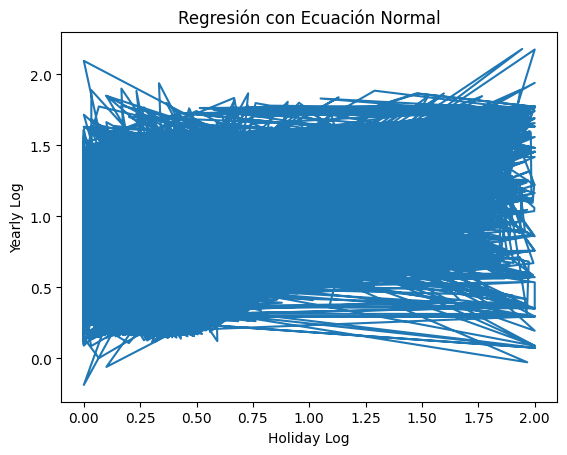

In [36]:
plt.figure()
plt.plot(X[:, 1], np.dot(X_with_bias, theta2), '-')
plt.xlabel('Holiday Log')
plt.ylabel('Yearly Log')
plt.title('Regresión con Ecuación Normal')
plt.show()

**(d) Generar Predicciones** Se realizan predicciones utilizando la ecuación de la normal calculada.

In [49]:
y_predicha = np.dot(X_ready[:200], theta2)
print(f"Datos predichos para los datos de prueba:")
print(y_predicha)

Datos predichos para los datos de prueba:
[0.48912804 0.62769335 0.56767037 0.48535304 0.54022679 0.45445527
 0.71977085 0.64167298 0.44445378 0.33592291 0.62790015 0.51885072
 0.53630782 0.64359658 0.38206247 0.53229724 0.66290376 0.44634996
 0.47340348 0.78019264 0.68429602 0.40737712 0.4786909  0.50916817
 0.66206307 0.43649991 0.54513189 0.45436829 0.33450219 0.43975555
 0.43986551 0.63479622 0.41352251 0.53639163 0.48965006 0.64464472
 0.54077729 0.57802535 0.65876218 0.56535177 0.58518817 0.51023711
 0.44165427 0.57781998 0.5268079  0.57327274 0.48663703 0.41948085
 0.57639508 0.57012549 0.40074    0.37820894 1.32467092 1.19715759
 1.34316835 1.42334274 1.45568102 0.47341963 0.45162641 0.51340945
 0.6924872  0.53000589 0.53644158 0.49047231 0.55514023 0.38020307
 0.75170165 0.35526973 1.30144058 0.51068029 0.62558803 0.46110603
 0.5079299  0.56052708 0.50008204 0.5538891  0.33426017 0.50329272
 0.67843836 0.45226214 0.82007786 1.57964255 0.74418703 0.74896376
 0.39317447 0.406043

**Conclusiones.** El tiempo de respuesta depende de la cantidad de datos proporcionados, como en este caso el dataset tiene 17 parámetros theta a calcular (16 columnas) y al menos más de 100000 filas, se esperaba que tarde. El tiempo promedio al hacer el descenso por la gradiente fue de 3 minutos.
Dentro de los resultados predictivos (Yearly Log) podemos concluir que el más preciso es el de la ecuación de la normal.

In [50]:
y_predicha = np.dot([1, 0.3947858243, 0.398009861379, 0.40582621258900003, 0.40582621258900003, 0.40582621258900003, 0.40582621258900003, 0.40582621258900003, 0.48926666848000006,
                     0.415286354062, 0.40501759295699996, 0.40389494835999995, 0.40501759295699996, 0.40501759295699996, 0.403464935188, 0.5194703981854151, 0.4244997945896438], theta)
print(y_predicha)


datos_prediccion = np.array([[1, 0.3947858243, 0.398009861379, 0.40582621258900003, 0.40582621258900003, 0.40582621258900003, 0.40582621258900003, 0.40582621258900003, 0.48926666848000006,
                             0.415286354062, 0.40501759295699996, 0.40389494835999995, 0.40501759295699996, 0.40501759295699996, 0.403464935188, 0.5194703981854151, 0.4244997945896438]])
prediccion_polynomial = pf.transform(datos_prediccion)
y_predicha = regresion_lineal.predict(prediccion_polynomial)
print(y_predicha)


y_predicha = np.dot([1, 0.3947858243, 0.398009861379, 0.40582621258900003, 0.40582621258900003, 0.40582621258900003, 0.40582621258900003, 0.40582621258900003, 0.48926666848000006,
                     0.415286354062, 0.40501759295699996, 0.40389494835999995, 0.40501759295699996, 0.40501759295699996, 0.403464935188, 0.5194703981854151, 0.4244997945896438], theta2)
print(y_predicha)

0.1486329084520783
[0.71669245]
0.7620201648513331
